# Introduction to sampling

**INM-6 Book club, 11 Oct 2019**<br>
**Alexandre René**

In [1]:
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import theano
import theano.tensor as tt
import pymc3 as pm
import theano_shim as shim
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from sampling_tutorial.utils import cDist, effective_n
import sampling_tutorial.utils as utils
from imp import reload

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Hands-on preparation

    cd ~   # Or whatever directory you use for tutorials
    git clone https://github.com/alcrene/sampling-tutorial.git
    cd sampling-tutorial
    bash ./install.sh
    ./START

# Topics
- What is sampling it good for ?
- How does it work?
  + **Typical set**
  + Markov Chain Monte Carlo
    + **Transition invariance**
  + <span style="color:#888888">Nested sampling</span>
- The classic sampler: Metropolis-Hastings algorithm
- What the cool kids do: Hamiltonian Monte Carlo
  + Standard algorithm
  + Automatically tuned version (NUTS)

# Material

<table>
  <tr>
    <td><em>Information Theory, Inference and Learning Algorithms</em> <br> (Mackay, 2003), Chaps 4, 29, 30</td><td><img width="200px" src="images/Mackay_cover.png"></td>
  </tr>
  <tr>
    <td><em><a href=https://arxiv.org/abs/1701.02434>A Conceptual Introduction to Hamiltonian Monte Carlo</a></em><br>(Betancourt, 2017)</td><td><img width="200px" src="images/A_conceptual_introduction_to_Hamiltonian_Monte_Carlo_abstract.png"></td>
  </tr>
  <tr>
    <td><em><a href=https://projecteuclid.org/euclid.ba/1340370944>Nested sampling for general Bayesian computation</a></em><br>(Skilling, 2006)</td><td><img width="200px" src="images/Nested_sampling_for_general_Bayesian_computation_abstract.png"></td>
  </tr>
</table>

# What is it good for ?
<img src=images/problems_to_be_solved.png width="600px">

- **Remark 1** It is sufficient to be able to compute $P$ up to a scaling factor. This is useful because often the normalization factor (*partition function*, or Bayesian *evidence*) is the hardest to compute.

- **Remark 2** Precisely because of Remark 1, it is not trivial to obtain the evidence from a Monte Carlo estimate.

## Monte Carlo estimate of expectations

Given a set of samples $x_i \sim P$, the expectation over $P$ can be approximated as
$$\begin{aligned}
Φ = \langle\phi(x)\rangle &= \int \mathrm{d}^N\!x\, P(x) \phi(x) \\
    &\approx \frac{1}{N} \sum_{i=1}^N \phi(x)
\end{aligned}$$

- **Remark 3** The accuracy of such a Monte Carlo estimate of depends only on the variance of $P$. In particular, it does **not depend the number of dimensions**.
- **Remark 4** Only **independent** samples count.

# How does it work

## Typicality
Consider the following distribution and function $φ$.

In [2]:
from collections import Callable

class Function:
    def __init__(self, domain, image, domainlabel='x', funclabel='f'):
        if isinstance(image, Callable):
            image = image(domain)
        self.domain = domain
        self.image = image
        self.domainlabel = domainlabel
        self.funclabel = funclabel
    def plot(self, *args, include_zero=True, **kwargs):
        sns.set_style('ticks')
        ax = sns.lineplot(self.domain, self.image, *args, **kwargs)
        # Set x ticks
        xticks = [self.domain[0], self.domain[-1]]
        if np.prod(xticks) < 0:
            xticks.insert(1, 0)
        if include_zero:
            if np.min(self.image) > 0: ax.set_ylim(ymin=0)
            elif np.max(self.image) < 0: ax.set_ylim(ymax=0)
        ax.set_xticks(xticks)
        # Set y ticks
        ax.yaxis.set_major_locator(plt.MaxNLocator(3))
        # Despine
        sns.despine(ax=ax, trim=True)
        # Set labels
        ax.set_xlabel(f"${self.domainlabel}$")
        ax.text(0.9, 0.9, f"${self.funclabel}({self.domainlabel})$",
                fontsize=14,
                ha='right', transform=ax.transAxes)
        return ax
    
class PDF(Function):
    def __init__(self, domain, pdf, domainlabel='x', funclabel='P'):
        super().__init__(domain, pdf, domainlabel, funclabel)
        self.image /= np.trapz(self.image, self.domain)

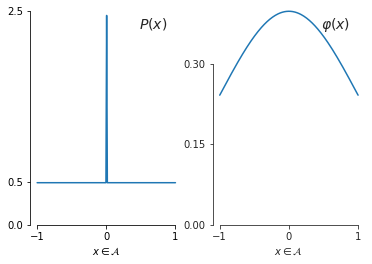

In [3]:
plt.subplot(121)
x = np.linspace(-1, 1, 200)
p = np.ones(x.shape); p[100] = 5
ax = PDF(x, p).plot();
ax.set_xlabel('$x \in \mathcal{A}$');
ax.set_yticks([0, 0.5, 2.5])
sns.despine(trim=True)

plt.subplot(122)
ax = Function(x, stats.norm().pdf, funclabel='φ').plot();
ax.set_xlabel('$x \in \mathcal{A}$');

When evaluating $\int_\mathcal{A} P(x) φ(x) dx$, what matters most:
- The most likely value ($x=0$) ?
- Or the set of points $\left\{x : P(x) = 0.5\right\}$ ?

## Typicality

Another example: Consider $N$ binary random variables (spins, 0-1, coin flips, whatever) with $p_\uparrow = 1/3$ and $p_\downarrow = 2/3$.
- The most likely state is to have all spins $\uparrow$.
- But the most "typical" state is to have 1/3 $\uparrow$, 2/3 $\downarrow$.

## Typical set

Let $H$ be the average information content of a single event $\left(H = \sum_i p_i \log_2 \frac{1}{p_i}\right)$ and $N$ the number of events. The ensemble of events in the **typical set** are those whose *surprise* is within a distance $β$ of $NH$:

$$T = \left\{ x \in \mathcal{A} : \left\lvert \frac{1}{N} \log_2 \frac{1}{P(x)} - H \right\rvert < β \right\}$$

<p style="text-align:right; text-color:gray">c.f. Mackay §4.4</p>

In [2]:
XX, YY = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
XY = np.stack((XX, YY), axis=2)

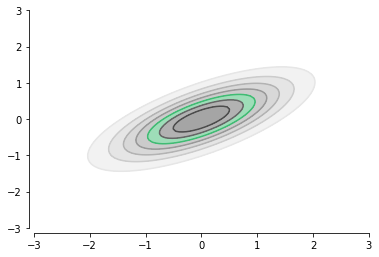

In [5]:
n = 8
c = list(np.broadcast_to(1-np.arange(n)*0.8/n, (3,n)).T)
c[-3] = '#3fbc73'
ZZ = stats.multivariate_normal(mean=[0,0], cov=[[1, 0.5],[0.5, 0.5]]).pdf(XY)
plt.contourf(XX, YY, ZZ, levels=8, colors=c, alpha=0.5)
plt.contour(XX, YY, ZZ, levels=8, colors=c)
sns.despine(trim=True, offset=5)

## Transition invariance (MCMC)

All MCMC samplers construct a chain of samples $x^{(1)}$, $x^{(2)}$… from a *transition probability*:
$$p\left(x'\right) \sim T\left(x', x^{(t)}\right) \,.$$

Algorithms define the transition probability $T$ different, but it they must always have the following properties:

- The desired distribution $p^*(x)$ must be *invariant* under $T$: <br>
  $\displaystyle p^*(x') = \int d^N\!x \; T(x', x)\, p^*(x)$.
- The chain is *ergodic*: <br>
  $\displaystyle p^{(t)}(x) \to p^*(x)$ as $t \to \infty$, for any $p^{(0)}(x)$.

# Examples of sampling algorithms

To illustrate sampling algorithms, I will use a distribution defined as follows:

- Take $c, x \in \mathbb{R}^2$ and $f(x) = \begin{pmatrix}x_0^2 - x_1^2 \\ 2 x_0 x_1\end{pmatrix} + c \,.$
- Define $\mathcal{D}_n(s)$, $n \in 1, 2, \dotsc$ to be the distribution with the p.d.f. proportional to :
    $$p(c) \propto \exp\bigl[- \lVert \underbrace{f( \dotso f}_{\text{$n$ times}}(s)\dotso)\rVert_1 \bigr]$$

We set $s = \begin{pmatrix}0\\0\end{pmatrix}$ for now.

The variable $n$ controls the complexity of the distribution, going from a simple unimodal distribution with $n=1$ to increasingly more complex distributions as $n$ is increased.

In [3]:
with pm.Model() as known_model:
    c = cDist('c', n=2, s=(0.,0.))

<span style="color: #888888">(<code style="color: #888888">cDist</code> is imported from <code style="color: #888888">sampling_tutorial.utils</code>)</span>

In [5]:
known_model

In [4]:
_truedist = cDist.logp(cDist.dist(n=2, s=(0.,0.)), XY)
truedist = pd.DataFrame(np.exp(_truedist - _truedist.max()),
                        index=np.round(XX[0,:], 3), columns=np.round(YY[:,0], 3))

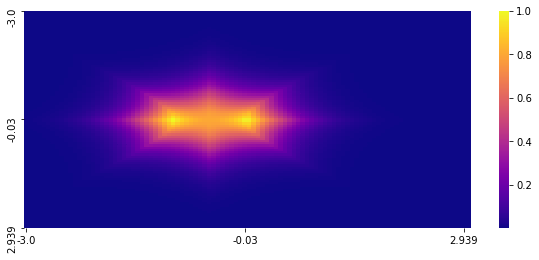

In [45]:
ax = sns.heatmap(truedist, cmap='plasma', xticklabels=49, yticklabels=49);

In [6]:
ndraws = 40000  # Use the same number of draws for all samples

## Metropolis-Hastings MCMC

<p style="margin:0; padding:0">First</p>
<ol style="list-style:lower-roman; margin:0">
    <li>Fix a proposal distribution $Q\left(x'; x^{(t)}\right)$ which depends on $x^{(t)}$ (usually a Gaussian).
    <li>Select $x^{(t)} = x^{(0)}$ (usually by sampling the prior).
</ol>

<p style="margin:0; padding:0">Then repeat the following</p>
<ol style="margin:0;">
    <li>Sample $x' \sim Q(x'; x^{(t)})$
    <li>Evaluate the <em>acceptance ratio</em> $\displaystyle a = \frac{p^*(x')}{p^\left(x^{(t)}\right)} \frac{Q\left(x^{(t)}, x'\right)}{Q\left(x'; x^{(t)}\right)}$.
    <li>If $a \geq 1$, accept the new state.<br>
        Otherwise, accept with probability $a$.
    <li>If new state is accepted, set $x^{(t+1)} = x'$<br>
        Otherwise, set $x^{(t+1)} = x^{(t)}$.
</ol>

**Main parameters**

- Proposal distribution $Q$.
- Step size $ε$.

![](images/Metropolis_random-walk.png)

In [7]:
with known_model:
    Metropolis_trace = pm.sample(draws=ndraws, chains=2,
                                 step=pm.Metropolis(S=None,
                                                    proposal_dist=None,
                                                    scaling=1.))

Multiprocess sampling (2 chains in 4 jobs)
Metropolis: [c]
Sampling 2 chains: 100%|██████████| 81000/81000 [00:07<00:00, 10538.22draws/s]
The number of effective samples is smaller than 10% for some parameters.


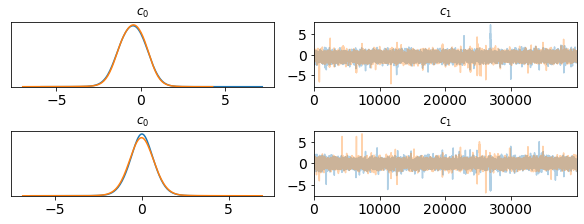

In [8]:
axes = pm.traceplot(Metropolis_trace);
utils.format_traceplot(axes);

In [47]:
utils.effective_n(Metropolis_trace)

,effective sample size,total samples
$c_0$,8290,80000
$c_1$,9010,80000


In [14]:
def f(nsamples=ndraws, window=7.):
    axes = az.plot_joint(Metropolis_trace[:nsamples], kind='hexbin', joint_kwargs={'cmap':'plasma'});
    utils.format_joint_plot(axes, window)
interact(f, nsamples=(0, ndraws), window=(0., 10.));

interactive(children=(IntSlider(value=40000, description='nsamples', max=40000), FloatSlider(value=7.0, descri…


| Metropolis samples | True distribution |
|----|---|
| ![](images/Metropolis_sampled_dist.png) | ![](images/True_dist.png) |

### Property of Metropolis-Hastings

- Steps are computationally cheap
- Computationally robust (discontinuous probabilities will not cause it to fail)
- Random-walk behaviour ⇒ need lots of samples 

<img width="500px" src=images/Metropolis_nsamples.png>

## Hamiltonian Monte Carlo

<img width="500px" src="images/HMC_motivation.png">

Requires:

- Continuous random variable
- Differentiable probability

## Hamiltonian Monte Carlo

- Augment the state space $x$ by a momentum variable $p$ <br>
  $\displaystyle H(x,p) = E(x) + K(p)$.
- Sample from the joint density
  $\displaystyle P_H(x,p) = \frac{1}{Z_H} \exp\left[-H(x,p)\right] = \frac{1}{Z_H} \exp\left[-E(x)\right]\exp\left[-K(p)\right]$.
- The density is separable, so we just discard $p$ to obtain samples $\left\{x^{(t)}\right\}$ distributed according to $P(x)$.

<p style="text-align:right; text-color:gray">Taken from Mackay §30.1</p>

1. Draw a new momentum from the Gaussian density $\exp[-K(p)]/Z_K$.
2. Use a numerical integrator (usu. leap-frog) to integrate the dynamics equations for a certain number of steps.
   $$\begin{aligned}
   \dot{x} &= p \\
   \dot{p} &= -\frac{\partial E(x)}{\partial x}
   \end{aligned}$$
    The result of the integration is a proposal $(x', p')$.
3. Accept the propopsal according to the Metropolis rule.

Remark: If integration was perfect, we would always accept.

![](images/HMC-vs-Metropolis.png)

### Why HMC works so well

- Avoids random walk behaviour; <img width="300px" src="images/energy_levels.png" style="float:right"> <br>
  "Slings" samples to a far away point with the same energy
- Energy corresponds to typical set.
- In high-dimensions, the typical is a thin ring far from the mode.

<img width="600px" src="images/Typical_set_cartoon.png">

In [58]:
with known_model:
    HMC_trace = pm.sample(draws=ndraws, chains=4,
                          step=pm.HamiltonianMC(path_length=2,
                                                step_scale=0.25,
                                                scaling=None,  # Inverse mass matrix
                                                target_accept=0.65,
                                                ))

Multiprocess sampling (4 chains in 4 jobs)
HamiltonianMC: [c]
Sampling 4 chains: 100%|██████████| 162000/162000 [00:32<00:00, 5025.64draws/s]
The number of effective samples is smaller than 25% for some parameters.


Remark: PyMC3 does some automatic tuning of step size.

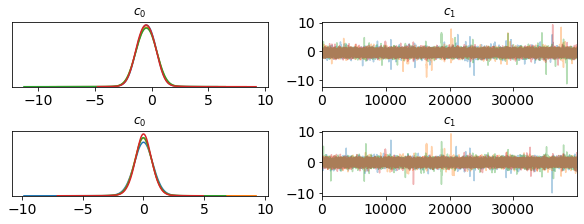

In [52]:
axes = pm.traceplot(HMC_trace);
utils.format_traceplot(axes);

In [46]:
utils.effective_n(HMC_trace)

,effective sample size,total samples
$c_0$,42300,160000
$c_1$,52800,160000


In [53]:
def f(nsamples=ndraws, window=7.):
    axes = az.plot_joint(HMC_trace[:nsamples], kind='hexbin', joint_kwargs={'cmap':'plasma'});
    utils.format_joint_plot(axes, window)
interact(f, nsamples=(0, ndraws), window=(0., 10.));

interactive(children=(IntSlider(value=40000, description='nsamples', max=40000), FloatSlider(value=7.0, descri…


| HMC samples | True distribution |
|----|---|
| ![](images/HMC_sampled_dist.png) | ![](images/True_dist.png) |

### Properties of HMC

- Needs differentiable probability
- Targets typical set ⇒ More efficient sampling
- Many sampling parameters to tune. <br>
  There may not be a unique set of parameters which works well everywhere.

## Auto-tuned Hamiltonian Monte Carlo – NUTS

"No U-Turn" sampler. Principle: integrate HMC until you are as far away as possible from the starting point.

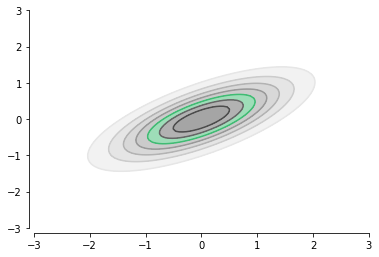

In [5]:
n = 8
c = list(np.broadcast_to(1-np.arange(n)*0.8/n, (3,n)).T)
c[-3] = '#3fbc73'
ZZ = stats.multivariate_normal(mean=[0,0], cov=[[1, 0.5],[0.5, 0.5]]).pdf(XY)
plt.contourf(XX, YY, ZZ, levels=8, colors=c, alpha=0.5)
plt.contour(XX, YY, ZZ, levels=8, colors=c)
sns.despine(trim=True, offset=5)

## Auto-tuned Hamiltonian Monte Carlo – NUTS

In [54]:
with known_model:
    NUTS_trace = pm.sample(draws=ndraws, init='jitter+adapt_diag', chains=4,
                           step=pm.NUTS())

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c]
Sampling 4 chains: 100%|██████████| 162000/162000 [01:08<00:00, 2352.47draws/s]


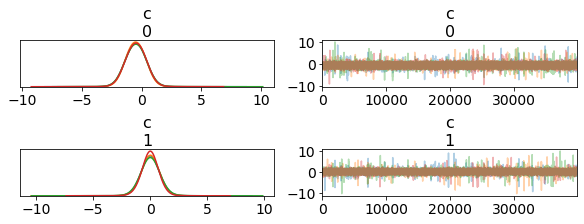

In [55]:
pm.traceplot(NUTS_trace);
utils.format_traceplot(axes);

In [56]:
utils.effective_n(NUTS_trace)

,effective sample size,total samples
$c_0$,76200,160000
$c_1$,65300,160000


In [57]:
def f(nsamples=ndraws, window=7.):
    axes = az.plot_joint(NUTS_trace[:nsamples], kind='hexbin', joint_kwargs={'cmap':'plasma'});
    utils.format_joint_plot(axes, window)
interact(f, nsamples=(0, ndraws), window=(0., 10.));

interactive(children=(IntSlider(value=40000, description='nsamples', max=40000), FloatSlider(value=7.0, descri…


| NUTS samples | True distribution |
|----|---|
| ![](images/NUTS_sampled_dist.png) | ![](images/True_dist.png) |

|Sampler | Posterior |
|--|--|
|True | ![](images/True_dist.png) |
|Metropolis | ![](images/Metropolis_sampled_dist.png) |
|HMC | ![](images/HMC_sampled_dist.png)
|NUTS | ![](images/NUTS_sampled_dist.png)|

# Inference example

In [28]:
L = len(HMC_trace)
data = np.zeros((L*HMC_trace.nchains, 2))
for i, strace in enumerate(HMC_trace._straces.values()):
    data[i*L:(i+1)*L] = strace.samples['c']

In [29]:
# Convert HMC samples into a dataset. We decimate by effective sample size to have only independent samples.
ess = utils.effective_n(HMC_trace)['effective sample size'].min()
data = data[::len(data)//ess]

In [33]:
with pm.Model() as unknown_model:
    s = pm.Normal(name='s', mu=np.array([0,0]), sd=np.array([10,10]), shape=(2,))
    c = cDist(name='c_u', n=2, s=s, observed=data)

In [34]:
unknown_model

In [35]:
with unknown_model:
    HMC_infer_trace = pm.sample(draws=1000, init='jitter+adapt_diag', chains=4,
                                step=pm.HamiltonianMC())

Multiprocess sampling (4 chains in 2 jobs)
HamiltonianMC: [s]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1281.51draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


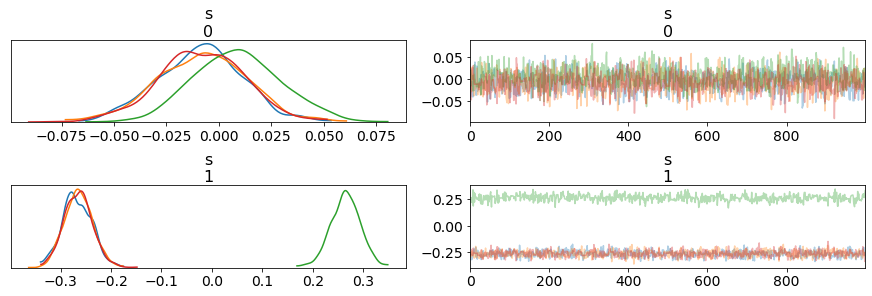

In [36]:
pm.traceplot(HMC_infer_trace);

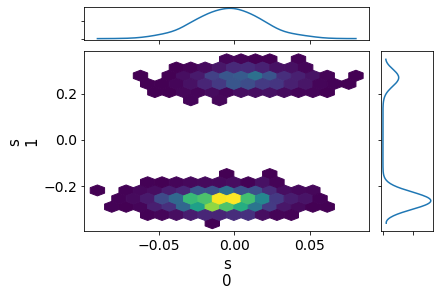

In [37]:
az.plot_joint(HMC_infer_trace, kind='hexbin');

In [135]:
effective_n(HMC_infer_trace)

,effective sample size
$z_0$,86500
$z_1$,93300


# Dealing with gnarly distributions

What makes a distribution difficult to sample ?
- Multiple modes
- Varying curvature
- Generally, the less Gaussian-like, the harder it is

MCMC trick:
- Reparameterize to make the distribution more Gaussian like

Particle-based sampling:
- Sequential Monte Carlo
- Nested sampling – no MCMC at all (Skilling 2006)

# Exercise questions

1. <span style="color:#AAAAAA">Compute the acceptance probability from `Metropolis_trace`.</span>
1. Play around with the Metropolis and HMC parameters. How do they effect the effective sample size ? <br>
   How do the Metropolis, HMC and NUTS compare in computation time ?
2. Find parameters such that Metropolis and HMC have the same effective sample size. Do the distributions look the same ?
3. Do the observations in (2) and (3) change when you make the distribution easier ($n=1$) or harder ($2 < n \lesssim 6$) ?
3. Can you adjust the HMC parameters so that it starts reproducing the thin arms in the $n = 2$ distribution ? Can you do so without changing the number of effective samples ? <br>
   <span style="color:#AAAAAA">How does that compare to the Metropolis algorithm ?</span>
4. Can you use sampling to infer $s$ from data ? (See [section on inference](#Inference-example)).
5. When inferring $s$, what effect does the prior on $s$ have on the posterior ?